Download the data

In [11]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2020-11-09 10:00:37--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.85.224.54, 52.85.224.11, 52.85.224.68, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.85.224.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  --.-KB/s    in 0.08s   

2020-11-09 10:00:37 (34.0 MB/s) - ‘data.zip.1’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/eng-fra.txt        
replace data/names/Arabic.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/names/Arabic.txt   
replace data/names/Chinese.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace data/names/Chinese.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace data/names/Chinese.txt? [y]

In [12]:
%matplotlib inline


Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [13]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string
import math

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('ÅšlusÃ rski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
train_data = {}
validation_data = {}
test_data = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.7*len(lines)))]
    validation_data[category] = lines[int(math.floor(0.7*len(lines)))+1:int(math.floor(0.85*len(lines)))]
    test_data[category] = lines[int(math.floor(0.85*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Portuguese.txt', 'data/names/Irish.txt', 'data/names/Greek.txt', 'data/names/German.txt', 'data/names/Japanese.txt', 'data/names/Arabic.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/Vietnamese.txt', 'data/names/Czech.txt', 'data/names/Spanish.txt', 'data/names/Chinese.txt', 'data/names/French.txt', 'data/names/Polish.txt', 'data/names/Korean.txt', 'data/names/Italian.txt', 'data/names/Russian.txt']
AslusA rski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [14]:
print(category_lines['Italian'][:5])

['Aiello', 'Aliberti', 'Lama', 'Martinelli', 'Sciarra']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [15]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <http://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [78]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, cell_size, output_size):
        super(RNN_LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.cell_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.LSTMCell(input_size + hidden_size + cell_size, hidden_size)
        # i2o is not necessary for LSTM, but to keep a fair comparison with RNN, we keep it 
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        combined_o = torch.cat((input, hidden), 1)
        combined_hc = torch.cat((input, hidden, cell), 1)
        hidden, cell = self.i2h(combined_hc, (hidden,  cell))
        output = self.i2o(combined_o)
        output = self.softmax(output)
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

    def initCell(self):
        return torch.zeros(1, self.cell_size)


class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_GRU, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.GRUCell(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined, hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


n_hidden = 128
n_cell = 128
rnn = RNN(n_letters, n_hidden, n_categories)      
rnn_lstm = RNN_LSTM(n_letters, n_hidden, n_cell, n_categories)
rnn_gru = RNN_GRU(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [25]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
cell = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [26]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
cell = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
output, next_hidden, next_cell = rnn_lstm(input[0], hidden, cell)
output, next_hidden = rnn_gru(input[0], hidden)
print(output)

tensor([[-2.9017, -2.8977, -2.9467, -2.8241, -2.8624, -2.8690, -2.9659, -2.8280,
         -2.9882, -2.9214, -2.9772, -2.9043, -2.8940, -2.8664, -2.9077, -2.9680,
         -2.8001, -2.7412]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [27]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Russian', 17)


We will also want a quick way to get a training example (a name and its
language):




In [28]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Irish / line = Doyle
category = German / line = Sulzbach
category = Arabic / line = Abboud
category = Dutch / line = Seelen
category = Czech / line = Dempko
category = Korean / line = Cha
category = Irish / line = Rodagh
category = Arabic / line = Guirguis
category = French / line = Tailler
category = Scottish / line = Kerr


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [29]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [82]:
optimizer_RNN = torch.optim.Adam(rnn.parameters())
optimizer_RNN_LSTM = torch.optim.Adam(rnn_lstm.parameters())
optimizer_RNN_GRU = torch.optim.Adam(rnn_gru.parameters())

def train_RNN(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    # reset gradient
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer_RNN.step()

    return output, loss.item()


def train_RNN_LSTM(category_tensor, line_tensor):
    hidden = rnn_lstm.initHidden()
    cell = rnn_lstm.initCell()

    # reset gradient
    rnn_lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden, cell = rnn_lstm(line_tensor[i], hidden, cell)

    loss = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer_RNN_LSTM.step()

    return output, loss.item()

  
def train_RNN_GRU(category_tensor, line_tensor):
    hidden = rnn_gru.initHidden()

    # reset gradient
    rnn_gru.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn_gru(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer_RNN_GRU.step()

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [ ]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss_rnn = 0
all_train_losses_rnn = []
all_validation_losses_rnn = []

train_loss_rnn_lstm = 0
all_train_losses_rnn_lstm = []
all_validation_losses_rnn_lstm = []

train_loss_rnn_gru = 0
all_train_losses_rnn_gru = []
all_validation_losses_rnn_gru = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate_RNN(line_tensor):
    hidden_rnn = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output_rnn, hidden_rnn = rnn(line_tensor[i], hidden_rnn)

    return output_rnn

# Train the RNN with Linear layer/cell
def eval_dataset_RNN(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate_RNN(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion

In [85]:
# Train and validate with linear hidden units
print('\nIter \tTrain% \tTime \t\tTrain_loss_rnn \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_RNN(category_tensor, line_tensor)
    train_loss_rnn += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'âœ“' if guess == category else 'âœ— (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss_rnn / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_rnn.append(train_loss_rnn / plot_every)
        train_loss_rnn = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss_rnn, _ = eval_dataset_RNN(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_rnn) == 0 or average_validation_loss_rnn < min(all_validation_losses_rnn):
            torch.save(rnn, 'char_rnn_classification_model.pt')
        all_validation_losses_rnn.append(average_validation_loss_rnn)



Iter 	Train% 	Time 		Train_loss_rnn 	Example
5000 	6% 	(0m 18s) 	1.9554 		Skala / Japanese âœ— (Czech)
10000 	12% 	(0m 40s) 	1.6548 		Sitta / Spanish âœ— (Czech)
15000 	18% 	(1m 2s) 	1.5018 		Sai / Chinese âœ— (Vietnamese)
20000 	25% 	(1m 24s) 	1.3423 		Coelho / Portuguese âœ“
25000 	31% 	(1m 46s) 	1.3652 		O'Connor / Irish âœ“
30000 	37% 	(2m 7s) 	1.2916 		Raghailligh / Russian âœ— (Irish)
35000 	43% 	(2m 29s) 	1.2194 		Jacques / Portuguese âœ— (English)
40000 	50% 	(2m 52s) 	1.2296 		Komiya / Japanese âœ“
45000 	56% 	(3m 13s) 	1.2144 		Allard / English âœ— (French)
50000 	62% 	(3m 35s) 	1.1878 		Napier / French âœ— (English)
55000 	68% 	(3m 56s) 	1.1707 		Shaw / Scottish âœ“
60000 	75% 	(4m 18s) 	1.1844 		Erizawa / Japanese âœ“
65000 	81% 	(4m 39s) 	1.1600 		Muir / Scottish âœ“
70000 	87% 	(5m 1s) 	1.1632 		Valencia / Italian âœ— (Spanish)
75000 	93% 	(5m 23s) 	1.2258 		Marek / Polish âœ“
80000 	100% 	(5m 44s) 	1.1439 		Campos / Portuguese âœ“


In [ ]:
# Train and validate with LSTM hidden units 
# Just return an output given a line
def evaluate_RNN_LSTM(line_tensor):
    hidden_rnn_lstm = rnn_lstm.initHidden()
    cell_rnn_lstm = rnn_lstm.initCell()

    for i in range(line_tensor.size()[0]):
        output_rnn_lstm, hidden_rnn_lstm, cell_rnn_lstm = rnn_lstm(line_tensor[i], hidden_rnn_lstm, cell_rnn_lstm)

    return output_rnn_lstm


def eval_dataset_RNN_LSTM(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate_RNN_LSTM(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion

print('\nIter \tTrain% \tTime \t\tTrain_loss_RNN_LSTM \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_RNN_LSTM(category_tensor, line_tensor)
    train_loss_rnn_lstm += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'âœ“' if guess == category else 'âœ— (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss_rnn_lstm / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_rnn_lstm.append(train_loss_rnn_lstm / plot_every)
        train_loss_rnn_lstm = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss_rnn_lstm, _ = eval_dataset_RNN_LSTM(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_rnn_lstm) == 0 or average_validation_loss_rnn_lstm < min(all_validation_losses_rnn_lstm):
            torch.save(rnn_lstm, 'char_lstm_classification_model.pt')
        all_validation_losses_rnn_lstm.append(average_validation_loss_rnn_lstm)


Iter 	Train% 	Time 		Train_loss_RNN_LSTM 	Example
5000 	6% 	(0m 49s) 	0.4158 		Madaidhin / Irish âœ“


In [ ]:
# Train and validate with GRU hidden units 
# Just return an output given a line
def evaluate_RNN_GRU(line_tensor):
    hidden_rnn_gru = rnn_lstm.initHidden()

    for i in range(line_tensor.size()[0]):
        output_rnn_gru, hidden_rnn_gru = rnn_gru(line_tensor[i], hidden_rnn_gru)

    return output_rnn_gru


def eval_dataset_RNN_GRU(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate_RNN_GRU(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion

print('\nIter \tTrain% \tTime \t\tTrain_loss_GRU \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_RNN_GRU(category_tensor, line_tensor)
    train_loss_rnn_gru += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'âœ“' if guess == category else 'âœ— (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss_rnn_gru / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_rnn_gru.append(train_loss_rnn_gru / plot_every)
        train_loss_rnn_gru = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss_rnn_gru, _ = eval_dataset_RNN_GRU(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_rnn_gru) == 0 or average_validation_loss_rnn_gru < min(all_validation_losses_rnn_gru):
            torch.save(rnn_gru, 'char_gru_classification_model.pt')
        all_validation_losses_rnn_gru.append(average_validation_loss_rnn_gru)

Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




[]


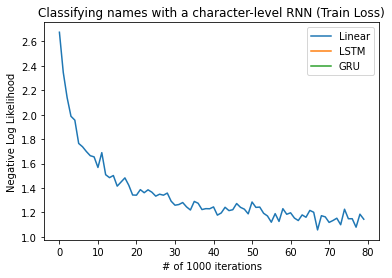

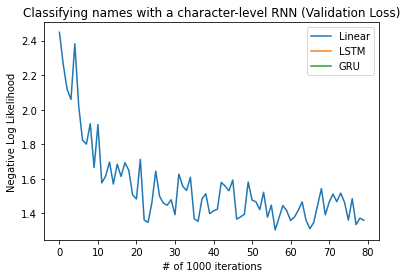

In [90]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses_rnn, label='Linear')
plt.plot(all_train_losses_rnn_lstm, label='LSTM')
plt.plot(all_train_losses_rnn_gru, label='GRU')
plt.title('Classifying names with a character-level RNN (Train Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['Linear', 'LSTM', 'GRU'], loc='upper right')

plt.figure()
plt.plot(all_validation_losses_rnn, label='Linear')
plt.plot(all_validation_losses_rnn_lstm, label='LSTM')
plt.plot(all_validation_losses_rnn_gru, label='GRU')
plt.title('Classifying names with a character-level RNN (Validation Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['Linear', 'LSTM', 'GRU'], loc='upper right')


Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




Average test loss RNN: 1.2657235185927607
Average test loss LSTM: 2.9004231662362545
Average test loss GRU: 2.9058800061437853


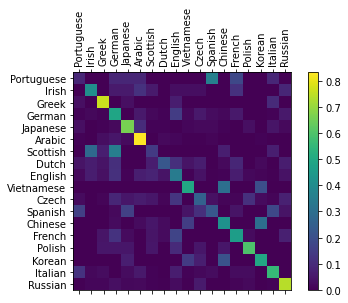

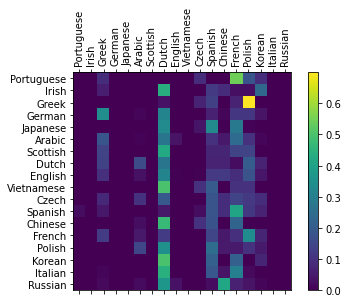

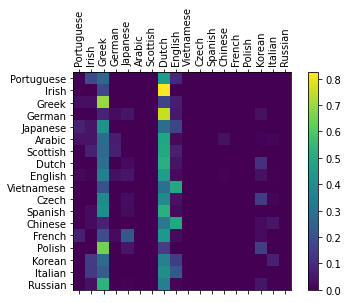

In [74]:
# evaluate on test set and display confusion matrix
rnn = torch.load('char_rnn_classification_model.pt')
rnn_lstm = torch.load('char_lstm_classification_model.pt')
rnn_gru = torch.load('char_gru_classification_model.pt')

average_test_loss_rnn, confusion_rnn = eval_dataset_RNN(test_data)
average_test_loss_rnn_lstm, confusion_rnn_lstm = eval_dataset_RNN_LSTM(test_data)
average_test_loss_rnn_gru, confusion_rnn_gru = eval_dataset_RNN_GRU(test_data)

print('Average test loss RNN: ' + str(average_test_loss_rnn))
print('Average test loss LSTM: ' + str(average_test_loss_rnn_lstm))
print('Average test loss GRU: ' + str(average_test_loss_rnn_gru))

# Set up plot
fig_rnn = plt.figure()
ax_rnn = fig_rnn.add_subplot(111)
cax_rnn = ax_rnn.matshow(confusion_rnn.numpy())
fig_rnn.colorbar(cax)

fig_lstm = plt.figure()
ax_lstm = fig_lstm.add_subplot(111)
cax_lstm = ax_lstm.matshow(confusion_rnn_lstm.numpy())
fig_lstm.colorbar(cax_lstm)

fig_gru = plt.figure()
ax_gru = fig_gru.add_subplot(111)
cax_gru = ax_gru.matshow(confusion_rnn_gru.numpy())
fig_gru.colorbar(cax_gru)


# Set up axes
ax_rnn.set_xticklabels([''] + all_categories, rotation=90)
ax_rnn.set_yticklabels([''] + all_categories)

ax_lstm.set_xticklabels([''] + all_categories, rotation=90)
ax_lstm.set_yticklabels([''] + all_categories)

ax_gru.set_xticklabels([''] + all_categories, rotation=90)
ax_gru.set_yticklabels([''] + all_categories)


# Force label at every tick
ax_rnn.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax_rnn.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax_lstm.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax_lstm.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax_gru.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax_gru.yaxis.set_major_locator(ticker.MultipleLocator(1))


# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [68]:
def predict(input_line, n_predictions=3, model='RNN'):
    print('\n> %s' % input_line)
    with torch.no_grad():
        if model == 'RNN':
            output = evaluate_RNN(lineToTensor(input_line))
        elif model == 'RNN_LSTM':
            output = evaluate_RNN_LSTM(lineToTensor(input_line))
        elif model == 'RNN_GRU':
            output = evaluate_RNN_GRU(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky', model='RNN')
predict('Jackson', model='RNN')
predict('Satoshi', model='RNN')

predict('Dovesky', model='RNN_LSTM')
predict('Jackson', model='RNN_LSTM')
predict('Satoshi', model='RNN_LSTM')

predict('Dovesky', model='RNN_GRU')
predict('Jackson', model='RNN_GRU')
predict('Satoshi', model='RNN_GRU')


> Dovesky
(-0.38) Russian
(-1.60) Czech
(-2.28) English

> Jackson
(-0.63) Scottish
(-1.70) English
(-2.16) Russian

> Satoshi
(-0.67) Arabic
(-1.52) Japanese
(-2.25) Polish

> Dovesky
(-2.80) Chinese
(-2.82) French
(-2.83) Italian

> Jackson
(-2.81) Dutch
(-2.83) Spanish
(-2.83) French

> Satoshi
(-2.79) Dutch
(-2.81) Chinese
(-2.83) Korean

> Dovesky
(-2.79) Greek
(-2.81) Dutch
(-2.82) Chinese

> Jackson
(-2.80) Greek
(-2.81) Dutch
(-2.82) Japanese

> Satoshi
(-2.78) English
(-2.79) Greek
(-2.80) Dutch


The final versions of the scripts `in the Practical PyTorch
repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with bottle.py)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.




Exercises
=========

-  Try with a different dataset of line -> category, for example:

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network


